<h1>Consumer Analysis: Driving Factors of Customer Satisfaction</h1>

What are the biggest driving factors of customer satisfaction? In a survey evaluating peoples experiences purchasing a variety of goods services, participants indicated which factors drove their purchasing choices. Partipants could choose from either previous experience with the provider, a recommendation from a friend, a recommendation from an aquaintence, low prices, company reputation, convenience, and their exposure to advertising. They then rated their degree of satisfaction with their purchasing decision. The following regression analyses reveal that some of these factors are predictors of customer satisfaction, while others are not. 

In [1]:
#Import Dependencies
from functions import regress
from functions import linregress
from functions import summarize
import pandas as pd
#Dependencies
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler
import pandas as pd
import sklearn
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
import numpy as np
import seaborn as sns
import pandas as pd
import statsmodels.api as sm

<h2>Aquiring and Cleaning the Data</h2>


In [2]:
#Convert data from Stata format to pandas dataframe
gss = pd.io.stata.read_stata('../data/GSS1996.dta',convert_categoricals=False)
itr = pd.read_stata('../data/GSS1996.dta', iterator = True)
gss.to_csv('../data/gss_converted.csv')

In [3]:
#Get list of relevant variable names
full_list=list(gss)
varlist=[]
for item in full_list:
    if item[0:3]=="car" or item[0:3]=="law" or item[0:3] == "fix" or item[0:6]== "realtor":
     varlist.append(item)

#Get list of control variable names
morevars=["degree","region","race","childs","sex","marital", "age"]
for item in morevars:
    varlist.append(item)

In [4]:
#Get varaible labels
labels=itr.variable_labels()
for item in varlist:
    print(f"{item}: {labels[item]}")

fixhome: home maintenance services past 10 years?
lawyer: hired a lawyer in the past 10 yrs? 
carprivt: have you purchased a used car past 5 yrs?
cardealr: purchased a car from a dealership past 5 yrs?
lawyerb: a friend or relative recommended them
lawyera: my own previous knowledge of the firm
lawyerd: general reputation in the community
lawyerc: an acquaintance recommended them.
lawyere: i saw their advertisement
lawyerf: i searched for the best price. 
fixerb: a friend or relative recommended them 
fixera: my own previous knowledge of the firm 
fixerf: i searched for the best price 
fixere: i saw their advertisement 
fixerd: general reputation in the community 
fixerc: an acquaintance recommended them. 
carbuyf: r searched for the best price
carbuya: r's own previous knowledge made r buy
carbuyg: convenience made r buy 
carbuyd: general reputation made r buy
carbuyb: a friend or relative recommended r buy 
carbuyc: an acquaintance recommended r buy
carbuye: r saw their advertisement

In [11]:
#Recode the Variables

#Dummy Variables: setting these from 1, 2 to 0,
dummylist = ["carprivt", "cardealr", "carbuyf", "carbuya", "carbuyg", "carbuyd", "carbuyb", "carbuyc", "carbuye", "carbuyf", "carbuy1", "realtora", "realtorb", "realtorc", "realtord", "realtore", "realtorf", "fixera", "fixerb", "fixerc", "fixerd", "fixere", "fixerf", "lawyera","lawyerb","lawyerc","lawyer","lawyere","lawyerf"]
for item in dummylist:
    gss[f"{item}_r"]=gss[item]
    gss.loc[(gss[item] ==1), f"{item}_r"] = 0
    gss.loc[(gss[item] ==2), f"{item}_r"] = 1

#Control Variables
#Recode sex to dummy, reference category = "female"
gss["sex_r"]=gss["sex"]
gss.loc[gss.sex == 1, 'sex_r'] = 0
gss.loc[gss.sex == 2, 'sex_r'] = 1

#Recode race to dummy, reference category = "nonwhite"
gss["race_r"]=gss["race"]
gss.loc[gss.race == 1, 'race_r'] = 0
gss.loc[gss.race > 1, 'race_r'] = 1

#Recode degree to dummy, reference category = "has no degree" (note that in original study, ref cat was HAS degree)
gss["degree_r"]=gss["degree"]
gss.loc[gss.degree <=3, 'degree_r'] = 0
gss.loc[gss.degree > 3, 'degree_r'] = 1

#Recode region to dummy, reference category = "Not from South"
gss["region_r"]=gss["region"]
gss.loc[(gss.region <=4) | (gss.region >7), 'region_r'] = 0
gss.loc[(gss.region >=5) & (gss.region <=7), 'region_r'] = 1

#Recode marital to new categorical variable with reference category = "single, never married" and divorced and separated categories combined (note that this differs slightly from the original study, which did not assign "0" to any value of the variable.)
#New categories:
#0=single, never married
#1=married
#2=divorced/separated
#3=widowed
gss["marital_r"]=gss["marital"]
gss.loc[(gss.marital ==5), 'marital_r'] = 0
gss.loc[(gss.marital ==4) | (gss.marital ==3), 'marital_r'] = 2
gss.loc[(gss.marital ==3), 'marital_r'] = 3

#Recode parent to dummy, reference category = "is not parent"
gss["childs_r"]=gss["childs"]
gss.loc[(gss.childs >0), 'childs_r'] = 1

#Center the age variable
gss["age_c"]=gss["age"]-gss["age"].mean()

In [6]:
#Drop all instances where no good or service was purchased, and create a separate dataframe for each (to prevent removing observations on relevant variables)
car=gss.dropna(subset=["carprivt"]).copy(deep=True)
home=gss.dropna(subset=["evbuyhme"]).copy(deep=True)
fix=gss.dropna(subset=["fixhome"]).copy(deep=True)
law=gss.dropna(subset=["lawyer"]).copy(deep=True)




FIXHOME



count    1444.000000
mean        1.618421
std         0.485942
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: fixhome, dtype: float64


Obs per category
------------------
1.0-> 551 (18.97%)
2.0-> 893 (30.75%)


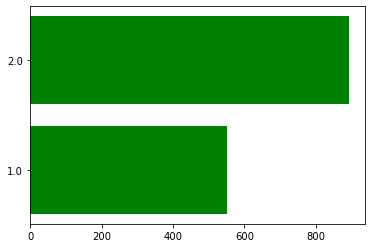




LAWYER



count    1444.000000
mean        1.549861
std         0.497680
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: lawyer, dtype: float64


Obs per category
------------------
1.0-> 650 (22.38%)
2.0-> 794 (27.34%)


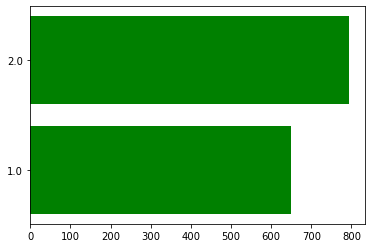




CARPRIVT



count    735.000000
mean       1.659864
std        0.474077
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: carprivt, dtype: float64


Obs per category
------------------
1.0-> 250 (8.61%)
2.0-> 485 (16.7%)


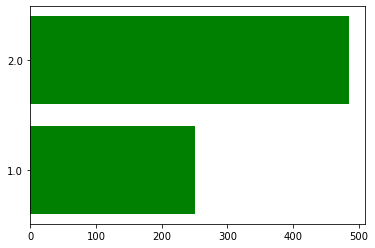




CARDEALR



count    728.000000
mean       1.451923
std        0.498025
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: cardealr, dtype: float64


Obs per category
------------------
1.0-> 399 (13.74%)
2.0-> 329 (11.33%)


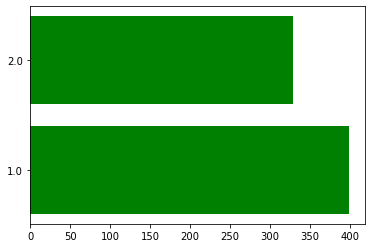




LAWYERB



count    549.000000
mean       1.491803
std        0.500389
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: lawyerb, dtype: float64


Obs per category
------------------
1.0-> 279 (9.61%)
2.0-> 270 (9.3%)


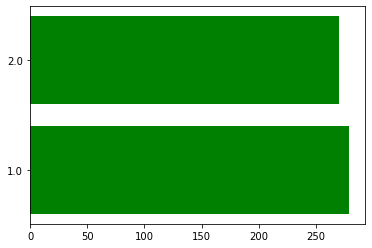




LAWYERA



count    539.000000
mean       1.634508
std        0.482015
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: lawyera, dtype: float64


Obs per category
------------------
1.0-> 197 (6.78%)
2.0-> 342 (11.78%)


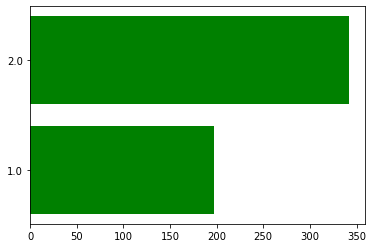




LAWYERD



count    523.00000
mean       1.74761
std        0.43480
min        1.00000
25%        1.00000
50%        2.00000
75%        2.00000
max        2.00000
Name: lawyerd, dtype: float64


Obs per category
------------------
1.0-> 132 (4.55%)
2.0-> 391 (13.46%)


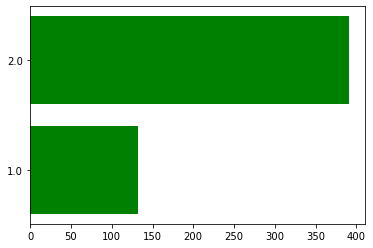




LAWYERC



count    516.000000
mean       1.782946
std        0.412640
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: lawyerc, dtype: float64


Obs per category
------------------
1.0-> 112 (3.86%)
2.0-> 404 (13.91%)


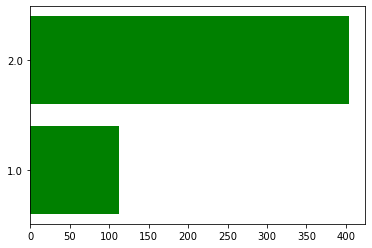




LAWYERE



count    505.000000
mean       1.857426
std        0.349985
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: lawyere, dtype: float64


Obs per category
------------------
1.0-> 72 (2.48%)
2.0-> 433 (14.91%)


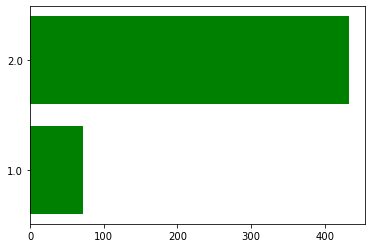




LAWYERF



count    498.000000
mean       1.909639
std        0.286987
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: lawyerf, dtype: float64


Obs per category
------------------
1.0-> 45 (1.55%)
2.0-> 453 (15.6%)


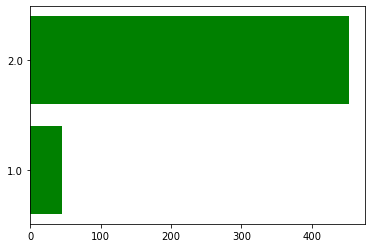




FIXERB



count    453.000000
mean       1.551876
std        0.497851
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: fixerb, dtype: float64


Obs per category
------------------
1.0-> 203 (6.99%)
2.0-> 250 (8.61%)


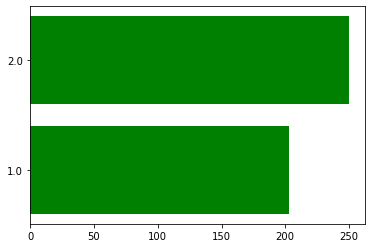




FIXERA



count    439.000000
mean       1.615034
std        0.487142
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: fixera, dtype: float64


Obs per category
------------------
1.0-> 169 (5.82%)
2.0-> 270 (9.3%)


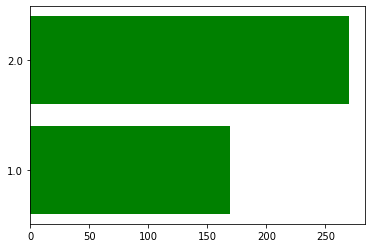




FIXERF



count    423.000000
mean       1.702128
std        0.457865
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: fixerf, dtype: float64


Obs per category
------------------
1.0-> 126 (4.34%)
2.0-> 297 (10.23%)


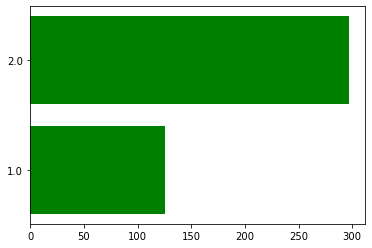




FIXERE



count    418.000000
mean       1.732057
std        0.443418
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: fixere, dtype: float64


Obs per category
------------------
1.0-> 112 (3.86%)
2.0-> 306 (10.54%)


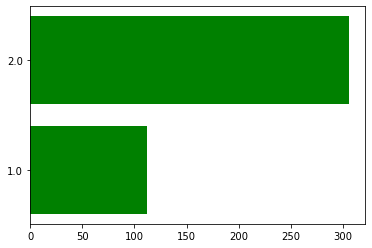




FIXERD



count    415.000000
mean       1.703614
std        0.457214
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: fixerd, dtype: float64


Obs per category
------------------
1.0-> 123 (4.24%)
2.0-> 292 (10.06%)


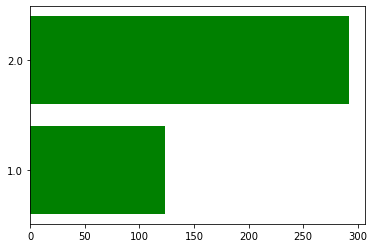




FIXERC



count    405.000000
mean       1.824691
std        0.380701
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: fixerc, dtype: float64


Obs per category
------------------
1.0-> 71 (2.44%)
2.0-> 334 (11.5%)


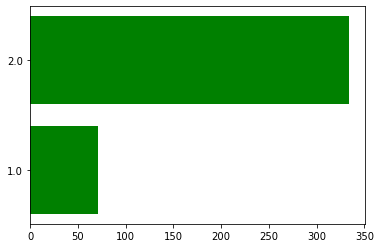




CARBUYF



count    334.000000
mean       1.497006
std        0.500741
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: carbuyf, dtype: float64


Obs per category
------------------
1.0-> 168 (5.79%)
2.0-> 166 (5.72%)


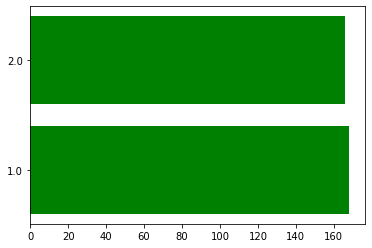




CARBUYA



count    330.000000
mean       1.612121
std        0.488007
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: carbuya, dtype: float64


Obs per category
------------------
1.0-> 128 (4.41%)
2.0-> 202 (6.96%)


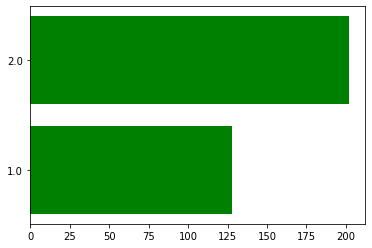




CARBUYG



count    324.000000
mean       1.626543
std        0.484470
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: carbuyg, dtype: float64


Obs per category
------------------
1.0-> 121 (4.17%)
2.0-> 203 (6.99%)


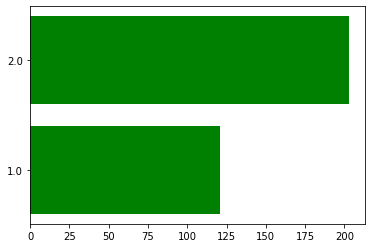




CARBUYD



count    316.000000
mean       1.661392
std        0.473987
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: carbuyd, dtype: float64


Obs per category
------------------
1.0-> 107 (3.68%)
2.0-> 209 (7.2%)


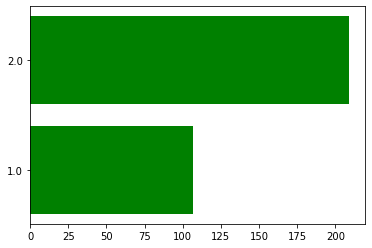




CARBUYB



count    315.000000
mean       1.647619
std        0.478472
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: carbuyb, dtype: float64


Obs per category
------------------
1.0-> 111 (3.82%)
2.0-> 204 (7.02%)


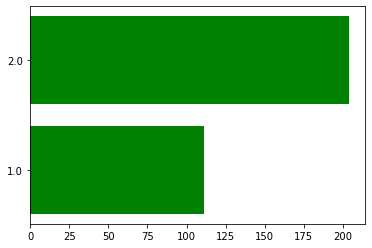




CARBUYC



count    305.000000
mean       1.875410
std        0.330796
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: carbuyc, dtype: float64


Obs per category
------------------
1.0-> 38 (1.31%)
2.0-> 267 (9.19%)


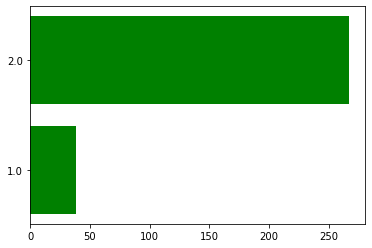




CARBUYE



count    305.000000
mean       1.740984
std        0.438815
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: carbuye, dtype: float64


Obs per category
------------------
1.0-> 79 (2.72%)
2.0-> 226 (7.78%)


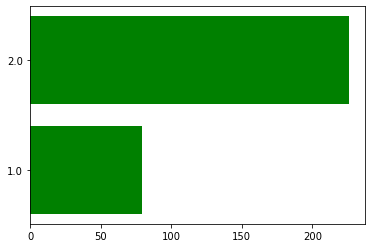




CARBUY1



count    186.000000
mean       4.306452
std        2.157992
min        1.000000
25%        2.000000
50%        5.500000
75%        6.000000
max        7.000000
Name: carbuy1, dtype: float64


Obs per category
------------------
1.0-> 35 (1.21%)
2.0-> 23 (0.79%)
3.0-> 5 (0.17%)
4.0-> 20 (0.69%)
5.0-> 10 (0.34%)
6.0-> 76 (2.62%)
7.0-> 17 (0.59%)


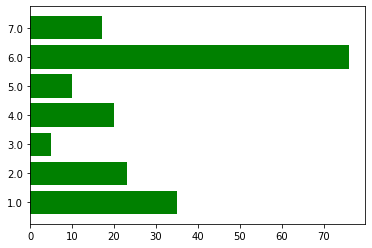




LAWYERG



count    173.000000
mean       1.791908
std        0.407122
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: lawyerg, dtype: float64


Obs per category
------------------
1.0-> 36 (1.24%)
2.0-> 137 (4.72%)


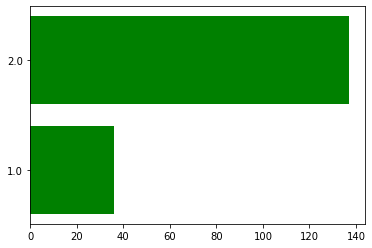




FIXER1



count    171.000000
mean       3.508772
std        2.015728
min        1.000000
25%        1.000000
50%        4.000000
75%        6.000000
max        6.000000
Name: fixer1, dtype: float64


Obs per category
------------------
1.0-> 44 (1.52%)
2.0-> 27 (0.93%)
3.0-> 10 (0.34%)
4.0-> 31 (1.07%)
5.0-> 6 (0.21%)
6.0-> 53 (1.83%)


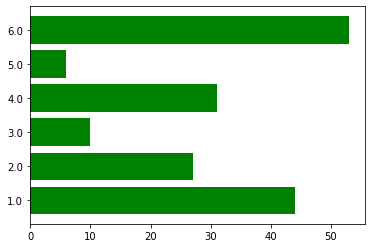




LAWYER1



count    158.000000
mean       2.696203
std        1.562738
min        1.000000
25%        1.250000
50%        2.000000
75%        4.000000
max        7.000000
Name: lawyer1, dtype: float64


Obs per category
------------------
1.0-> 40 (1.38%)
2.0-> 51 (1.76%)
3.0-> 17 (0.59%)
4.0-> 33 (1.14%)
5.0-> 4 (0.14%)
6.0-> 10 (0.34%)
7.0-> 3 (0.1%)


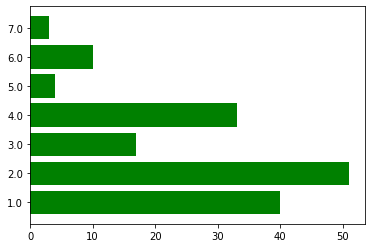




DEGREE



count    2897.000000
mean        1.467035
std         1.160929
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: degree, dtype: float64


Obs per category
------------------
0.0-> 448 (15.43%)
1.0-> 1567 (53.96%)
2.0-> 187 (6.44%)
3.0-> 471 (16.22%)
4.0-> 224 (7.71%)


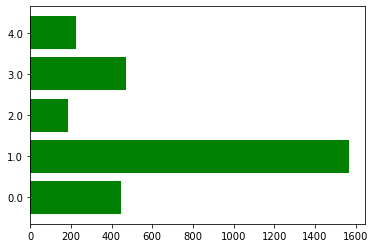




REGION



count    2904.000000
mean        4.988636
std         2.502126
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
max         9.000000
Name: region, dtype: float64


Obs per category
------------------
1-> 157 (5.41%)
2-> 412 (14.19%)
3-> 489 (16.84%)
4-> 210 (7.23%)
5-> 542 (18.66%)
6-> 209 (7.2%)
7-> 265 (9.13%)
8-> 200 (6.89%)
9-> 420 (14.46%)


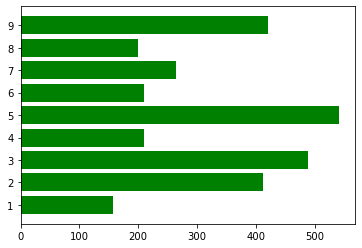




RACE



count    2904.000000
mean        1.243802
std         0.538362
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: race, dtype: float64


Obs per category
------------------
1-> 2349 (80.89%)
2-> 402 (13.84%)
3-> 153 (5.27%)


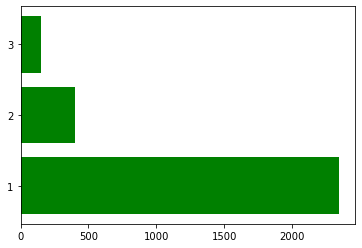




CHILDS



count    2889.000000
mean        1.833160
std         1.681493
min         0.000000
25%         0.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: childs, dtype: float64


Obs per category
------------------
0.0-> 822 (28.31%)
1.0-> 461 (15.87%)
2.0-> 770 (26.52%)
3.0-> 420 (14.46%)
4.0-> 222 (7.64%)
5.0-> 94 (3.24%)
6.0-> 48 (1.65%)
7.0-> 27 (0.93%)
8.0-> 25 (0.86%)


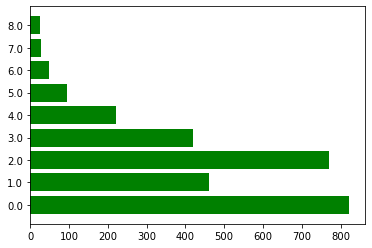




SEX



count    2904.000000
mean        1.557507
std         0.496767
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: sex, dtype: float64


Obs per category
------------------
1-> 1285 (44.25%)
2-> 1619 (55.75%)


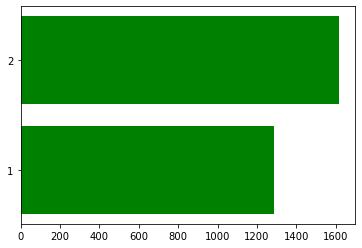




MARITAL



count    2903.000000
mean        2.439201
std         1.626688
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         5.000000
Name: marital, dtype: float64


Obs per category
------------------
1.0-> 1390 (47.87%)
2.0-> 282 (9.71%)
3.0-> 455 (15.67%)
4.0-> 118 (4.06%)
5.0-> 658 (22.66%)


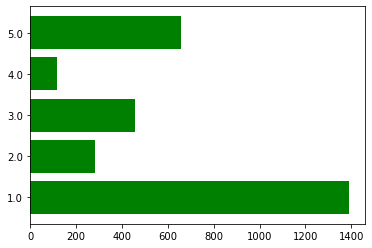




AGE



count    2898.000000
mean       44.777088
std        16.867696
min        18.000000
25%        32.000000
50%        42.000000
75%        55.000000
max        89.000000
Name: age, dtype: float64




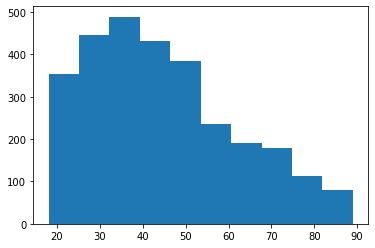

(array([353., 445., 489., 431., 384., 235., 190., 178., 114.,  79.]), array([18. , 25.1, 32.2, 39.3, 46.4, 53.5, 60.6, 67.7, 74.8, 81.9, 89. ]), <BarContainer object of 10 artists>)


In [19]:
#Get summary statistics and histogram for all variables
for item in varlist:
    print("\n"*2)
    print(item.upper())
    print("\n"*2)
    summarize(gss, item)

In [56]:
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np

In [10]:
#multiply impute the data to prep it for logistic regression analysis
reduced_copy=reduced.copy(deep=True)
X_filled_knn = KNN(k=3).fit_transform(reduced_copy)
reduced_mi=pd.DataFrame(X_filled_knn, columns=reduced_copy.columns)
reduced_mi.to_csv("../data/reduced_mi.csv")

NameError: name 'reduced' is not defined

In [58]:
#Read the CSV back in to avoid re-running the imputer later
reduced_mi=pd.read_csv("../data/reduced_mi.csv")

Optimization terminated successfully.
         Current function value: 0.630640
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      730
Method:                           MLE   Df Model:                            4
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                 0.01636
Time:                        03:00:11   Log-Likelihood:                -463.52
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                  0.003915
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8448      0.198      4.274      0.000       0.457       1.232
sex_r          0.450

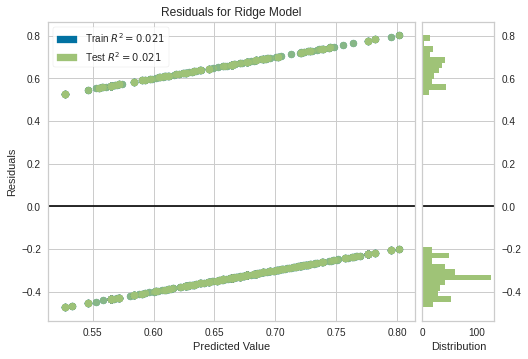

In [24]:
linregress(reduced_mi, "carprivt_r", "sex_r", "race_r", "marital_r", "carbuya_r")

In [22]:
from statsmodels.sandbox.predict_functional import predict_functional
#values = {"Sex1": "Female", "Sex":0, "AHD": 1, "Chol": 250}
pr, cb, fv = predict_functional(result, "age_c", ci_method="simultaneous")
ax = sns.lineplot(fv, pr, lw=4)
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.4)
ax.set_xlabel("Sex")
ax.set_ylabel("dv")

/home/ygael/anaconda3/envs/DataViz/lib/python3.8/site-packages/statsmodels/sandbox/predict_functional.py:169: ValueWarning: 'marital_r', 'newused_r', 'cardealr_r', 'satcar_r', 'degree_r', 'carbuyf_r', 'race_r', 'carbuyd_r', 'carbuyc_r', 'carbuya_r', 'region_r', 'sex_r', 'carbuyg_r', 'carbuy1_r', 'carbuye_r', 'carbuyb_r', 'childs_r' in data frame but not in summaries or values.
  warnings.warn("%s in data frame but not in summaries or values."


PatsyError: Error evaluating factor: NameError: name 'sex_r' is not defined
    carprivt_r ~ sex_r
                 ^^^^^

In [ ]:
gss_k3=gss_recoded.copy(deep=True)
X_filled_knn = KNN(k=3).fit_transform(gss_k3)
gss_knn=pd.DataFrame(X_filled_knn, columns=gss_recoded.columns)
gss_knn.to_csv("../data/gss_fancyimpute_knn.csv")

In [11]:
def linregress(*args):
    #import dependencies
    import sklearn as sk
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression()
    from sklearn import feature_selection
    import statsmodels.api as sm
    from patsy import dmatrices
    import numpy as np

    #define arguments
    dataframe=args[0]
    y=args[1]
    xvars=[]
    for i in range(2,len(args)):
        xvars.append(args[i])
    x = dataframe[[item for item in xvars]]
    y = dataframe[y]
    #fit the model
    model.fit(x,y)
    
    #Generate Fit Statistics
    ##prep data for patsy
    list=[]
    for item in xvars:
        list.append(f' + {item}')
    string="".join(list)
    newstring=string[3:]

    ind=args[1]
    ind=ind.strip('"')

    ##Fit the Model
    Y,X = dmatrices(f"{ind} ~ {newstring}", data=dataframe, return_type="dataframe")
    logit = sm.Logit(Y, X)
    logit_result = logit.fit()

    #Print Log Odds
    print("LOG ODDS")
    print(logit_result.summary())
    print(np.exp(logit_result.params))

    #Plot the Residuals
    print("\n Residual Plot")
    from sklearn.linear_model import Ridge
    from yellowbrick.datasets import load_concrete
    from yellowbrick.regressor import ResidualsPlot

    
    model = Ridge()

    visualizer = ResidualsPlot(model, fit=True)
    y2= y.values.reshape(-1, 1)
    visualizer.fit(x, y2)  # Fit the training data to the visualizer
    visualizer.score(x, y2)  # Evaluate the model on the test data
    visualizer.show()                 # Finalize and render the figure

    #predictions = model.predict(x)
    #plt.scatter(predictions, predictions - y, color='coral',linewidths=0.5)
    #plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max(), color='brown', linewidth=3)
    #plt.show()




Optimization terminated successfully.
         Current function value: 0.630640
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      730
Method:                           MLE   Df Model:                            4
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                 0.01636
Time:                        04:51:26   Log-Likelihood:                -463.52
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                  0.003915
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8448      0.198      4.274      0.000       0.457       1.232
sex_r          0.450

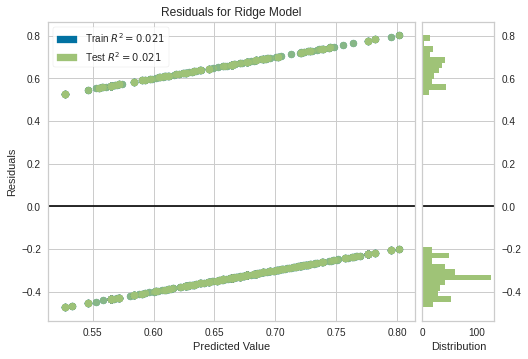

In [12]:
linregress(reduced_mi, "carprivt_r", "sex_r", "race_r", "marital_r", "carbuya_r")

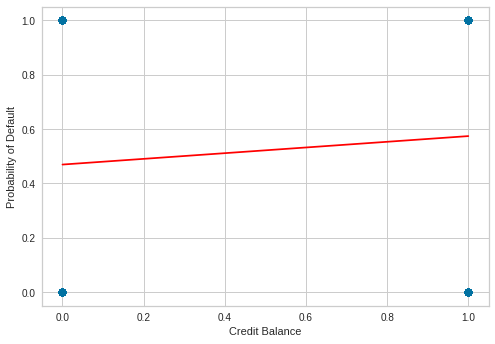

In [29]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
x=reduced_mi["carprivt_r"].values.reshape(-1,1)
y=reduced_mi["sex_r"].values.reshape(-1,1)

LogR = LogisticRegression()
LogR.fit(x,np.ravel(y.astype(int)))



plt.scatter(x,y)
plt.xlabel("Credit Balance")
plt.ylabel("Probability of Default")

plt.plot(x, LogR.predict_proba(x)[:,1], color='red')


<AxesSubplot:xlabel='carprivt_r', ylabel='carbuya_r'>

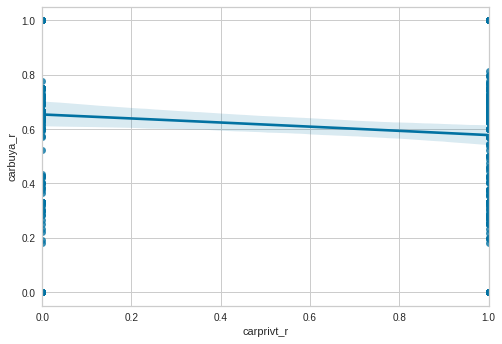

In [46]:
import seaborn as sns
sns.regplot(x='carprivt_r', y='carbuya_r', data=reduced_mi, logistic=True)

In [43]:
def linregress(*args):
    #import dependencies
    import sklearn as sk
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression()
    from sklearn import feature_selection
    import statsmodels.api as sm
    from patsy import dmatrices
    import numpy as np

    #define arguments
    dataframe=args[0]
    y=args[1]
    xvars=[]
    for i in range(2,len(args)):
        xvars.append(args[i])
    x = dataframe[[item for item in xvars]]
    y = dataframe[y]
    #fit the model
    model.fit(x,y)
    
    #Generate Fit Statistics
    ##prep data for patsy
    list=[]
    for item in xvars:
        list.append(f' + {item}')
    string="".join(list)
    newstring=string[3:]

    ind=args[1]
    ind=ind.strip('"')

    ##Fit the Model
    Y,X = dmatrices(f"{ind} ~ {newstring}", data=dataframe, return_type="dataframe")
    logit = sm.Logit(Y, X)
    logit_result = logit.fit()

    #Print Log Odds
    print("LOG ODDS")
    print(logit_result.summary())
    print(np.exp(logit_result.params))

    #Plot the Residuals
    print("\n Residual Plot")
    from sklearn.linear_model import Ridge
    from yellowbrick.datasets import load_concrete
    from yellowbrick.regressor import ResidualsPlot
    
    model = Ridge()

    visualizer = ResidualsPlot(model, hist=True)
    y2= y.values.reshape(-1, 1)
    visualizer.fit(x, y2)  # Fit the training data to the visualizer
    visualizer.score(x, y2)  # Evaluate the model on the test data
    visualizer.show()   

    from sklearn.linear_model import LogisticRegression
    x=x.values.reshape(-1,1)
    y=y.values.reshape(-1,1)

    LogR = LogisticRegression()
    LogR.fit(x,np.ravel(y.astype(int)))



    plt.scatter(x,y)
    plt.xlabel("Credit Balance")
    plt.ylabel("Probability of Default")

    plt.plot(x, LogR.predict_proba(x)[:,1], color='red')

Optimization terminated successfully.
         Current function value: 0.630640
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      730
Method:                           MLE   Df Model:                            4
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                 0.01636
Time:                        05:22:00   Log-Likelihood:                -463.52
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                  0.003915
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8448      0.198      4.274      0.000       0.457       1.232
sex_r          0.450

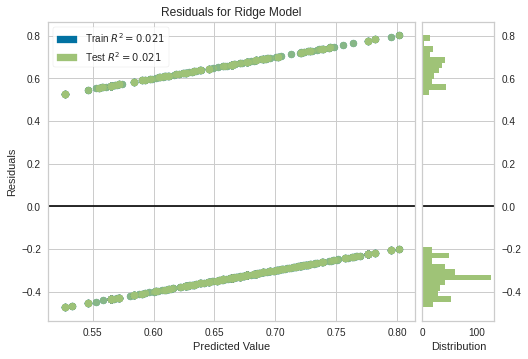

ValueError: Expected 2D array, got 1D array instead:
array=[1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1.
 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1.
 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1.
 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0.
 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1.
 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [44]:
linregress(reduced_mi, "carprivt_r", "sex_r", "race_r", "marital_r", "carbuya_r")

In [62]:
def linregress(*args):
    #import dependencies
    import sklearn as sk
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression()
    from sklearn import feature_selection
    import statsmodels.api as sm
    from patsy import dmatrices
    import numpy as np

    #define arguments
    dataframe=args[0]
    y=args[1]
    xvars=[]
    for i in range(2,len(args)):
        xvars.append(args[i])
    x = dataframe[[item for item in xvars]]
    y = dataframe[y]
    #fit the model
    model.fit(x,y)
    
    #Generate Fit Statistics
    ##prep data for patsy
    list=[]
    for item in xvars:
        list.append(f' + {item}')
    string="".join(list)
    newstring=string[3:]

    ind=args[1]
    ind=ind.strip('"')

    ##Fit the Model
    Y,X = dmatrices(f"{ind} ~ {newstring}", data=dataframe, return_type="dataframe")
    logit = sm.Logit(Y, X)
    logit_result = logit.fit()

    #Print Log Odds
    print("LOG ODDS")
    print(logit_result.summary())
    print(np.exp(logit_result.params))

    #Plot the Residuals
    print("\n Residual Plot")
    from sklearn.linear_model import Ridge
    from yellowbrick.datasets import load_concrete
    from yellowbrick.regressor import ResidualsPlot
    
    model = Ridge()

    visualizer = ResidualsPlot(model, hist=True)
    y2= y.values.reshape(-1, 1)
    visualizer.fit(x, y2)  # Fit the training data to the visualizer
    visualizer.score(x, y2)  # Evaluate the model on the test data
    visualizer.show()   

In [63]:
ivs=[item for item in newvars]
ivs.remove("carprivt_r")

Optimization terminated successfully.
         Current function value: 0.636862
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                0.006650
Time:                        05:46:52   Log-Likelihood:                -468.09
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                   0.01230
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8462      0.109      7.773      0.000       0.633       1.060
cardealr_r    -0.392

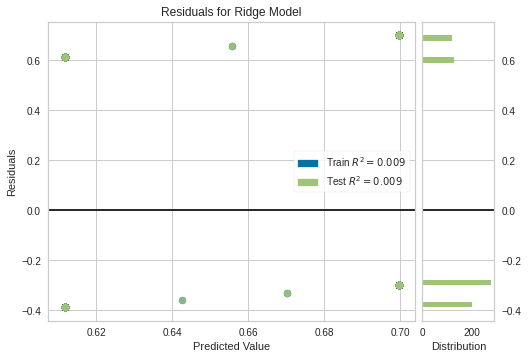

Optimization terminated successfully.
         Current function value: 0.640953
         Iterations 4
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:               0.0002693
Time:                        05:46:55   Log-Likelihood:                -471.10
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.6144
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6152      0.122      5.043      0.000       0.376       0.854
carbuyf_r      0.096

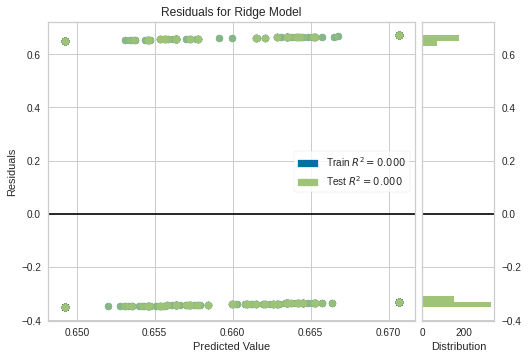

Optimization terminated successfully.
         Current function value: 0.637016
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                0.006410
Time:                        05:46:58   Log-Likelihood:                -468.21
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                   0.01398
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9627      0.148      6.503      0.000       0.673       1.253
carbuya_r     -0.486

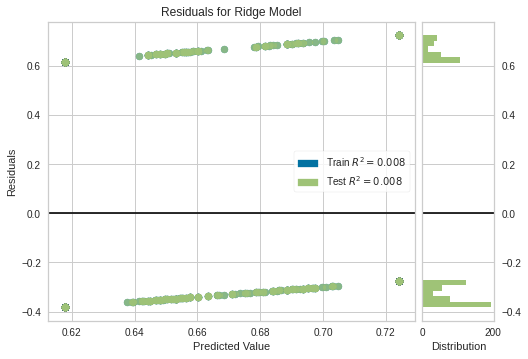

Optimization terminated successfully.
         Current function value: 0.641118
         Iterations 4
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:               1.209e-05
Time:                        05:47:01   Log-Likelihood:                -471.22
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.9150
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6492      0.149      4.371      0.000       0.358       0.940
carbuyg_r      0.021

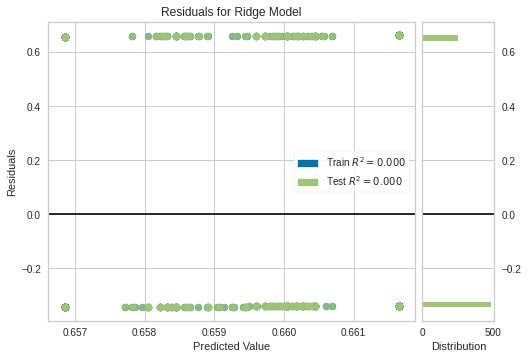

Optimization terminated successfully.
         Current function value: 0.638727
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                0.003741
Time:                        05:47:03   Log-Likelihood:                -469.46
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                   0.06041
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9269      0.164      5.664      0.000       0.606       1.248
carbuyd_r     -0.396

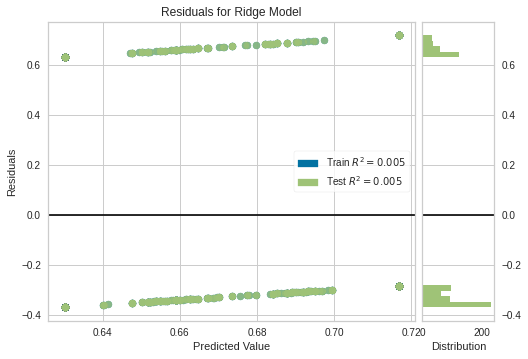

Optimization terminated successfully.
         Current function value: 0.640974
         Iterations 4
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:               0.0002365
Time:                        05:47:05   Log-Likelihood:                -471.12
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.6368
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7253      0.154      4.701      0.000       0.423       1.028
carbuyb_r     -0.095

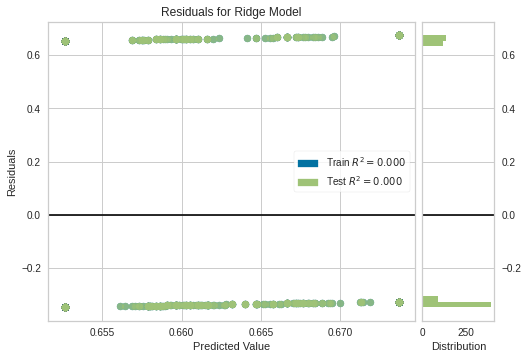

Optimization terminated successfully.
         Current function value: 0.641120
         Iterations 4
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:               8.908e-06
Time:                        05:47:07   Log-Likelihood:                -471.22
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.9270
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6390      0.269      2.374      0.018       0.111       1.167
carbuyc_r      0.027

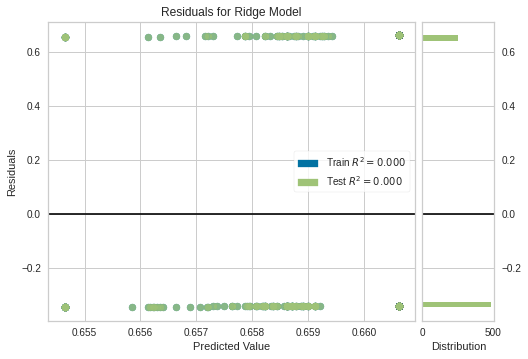

Optimization terminated successfully.
         Current function value: 0.641094
         Iterations 4
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:               4.991e-05
Time:                        05:47:09   Log-Likelihood:                -471.20
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.8283
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6998      0.188      3.717      0.000       0.331       1.069
carbuye_r     -0.049

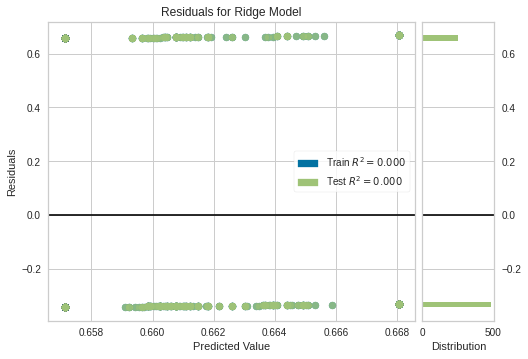

Optimization terminated successfully.
         Current function value: 0.631300
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                 0.01533
Time:                        05:47:12   Log-Likelihood:                -464.01
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                 0.0001444
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2751      0.186      6.851      0.000       0.910       1.640
carbuy1_r     -0.152

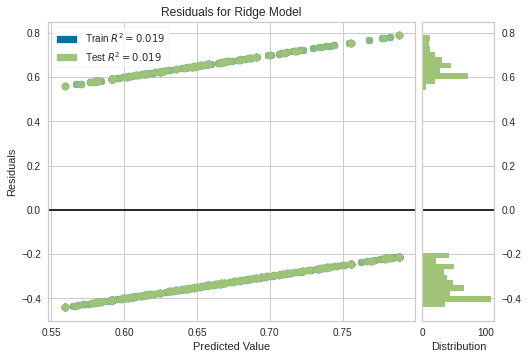

Optimization terminated successfully.
         Current function value: 0.640871
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:               0.0003978
Time:                        05:47:14   Log-Likelihood:                -471.04
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.5403
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6493      0.081      8.040      0.000       0.491       0.808
degree_r       0.185

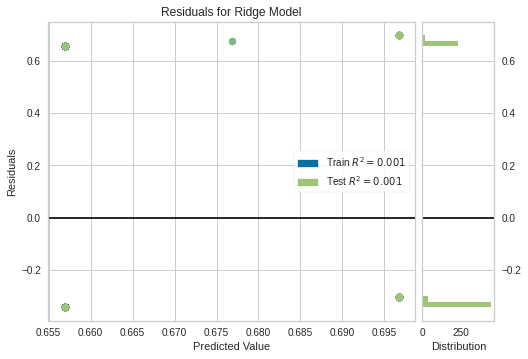

Optimization terminated successfully.
         Current function value: 0.640716
         Iterations 4
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:               0.0006392
Time:                        05:47:18   Log-Likelihood:                -470.93
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.4377
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6190      0.096      6.469      0.000       0.431       0.807
region_r       0.127

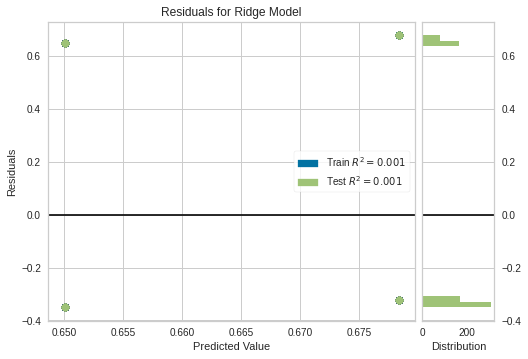

Optimization terminated successfully.
         Current function value: 0.641022
         Iterations 4
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:               0.0001616
Time:                        05:47:21   Log-Likelihood:                -471.15
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.6963
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6476      0.087      7.457      0.000       0.477       0.818
race_r         0.076

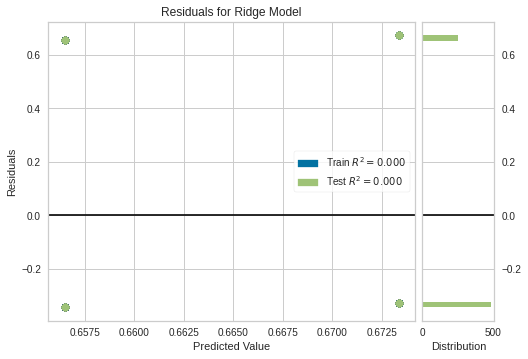

Optimization terminated successfully.
         Current function value: 0.641063
         Iterations 4
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:               9.713e-05
Time:                        05:47:24   Log-Likelihood:                -471.18
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.7622
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7004      0.147      4.756      0.000       0.412       0.989
childs_r      -0.052

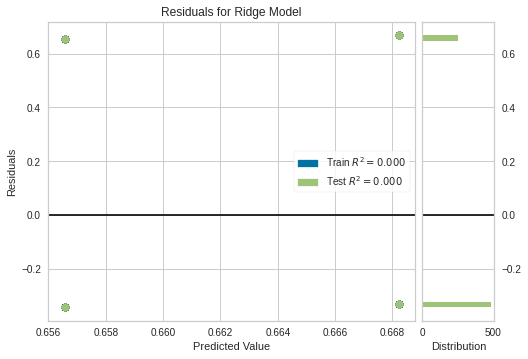

Optimization terminated successfully.
         Current function value: 0.635936
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                0.008095
Time:                        05:47:29   Log-Likelihood:                -467.41
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                  0.005743
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4375      0.111      3.933      0.000       0.220       0.656
sex_r          0.431

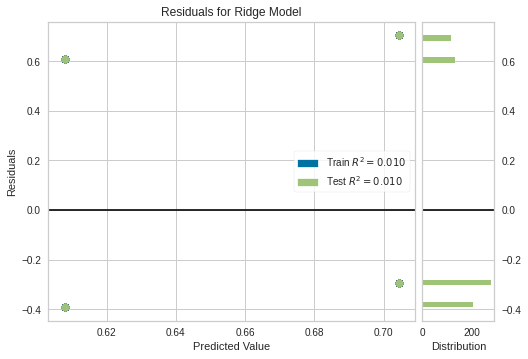

Optimization terminated successfully.
         Current function value: 0.640439
         Iterations 4
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                0.001071
Time:                        05:47:31   Log-Likelihood:                -470.72
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.3150
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7617      0.126      6.035      0.000       0.514       1.009
marital_r     -0.080

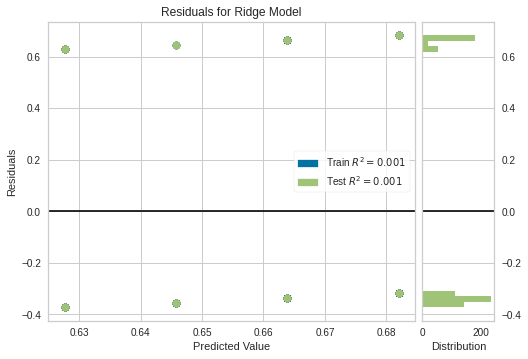

Optimization terminated successfully.
         Current function value: 0.637340
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                0.005905
Time:                        05:47:34   Log-Likelihood:                -468.44
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                   0.01832
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2879      0.175      1.643      0.100      -0.056       0.631
satcar_r       0.193

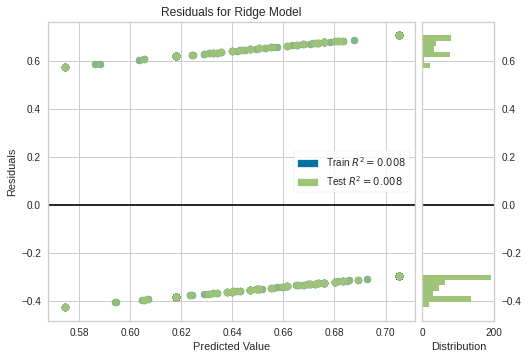

Optimization terminated successfully.
         Current function value: 0.622133
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                 0.02962
Time:                        05:47:37   Log-Likelihood:                -457.27
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                 1.264e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1661      0.129      9.024      0.000       0.913       1.419
newused_r     -0.986

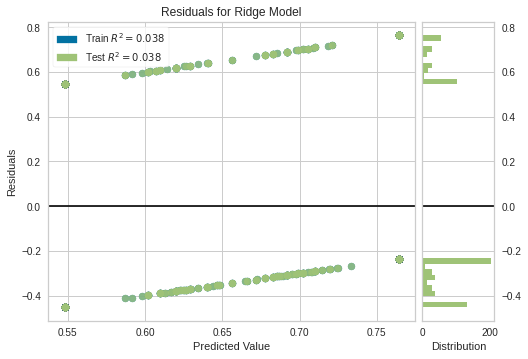

Optimization terminated successfully.
         Current function value: 0.610746
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                 0.04739
Time:                        05:47:41   Log-Likelihood:                -448.90
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                 2.345e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7170      0.082      8.737      0.000       0.556       0.878
age_c          0.033

KeyboardInterrupt: 

In [80]:
for item in ivs:
    linregress(reduced_mi, "carprivt_r", item)

In [75]:
satreduced=gss.dropna(subset=["satcar"])

In [74]:
#multiply impute the data to prep it for logistic regression analysis
gss_copy=gss.copy(deep=True)
X_filled_knn = KNN(k=3).fit_transform(gss_copy)
gss_mi=pd.DataFrame(X_filled_knn, columns=gss_copy.columns)
gss_mi.to_csv("../data/reduced_mi.csv")

Imputing row 1/735 with 672 missing, elapsed time: 19.170
Imputing row 101/735 with 648 missing, elapsed time: 20.708
Imputing row 201/735 with 639 missing, elapsed time: 22.270
Imputing row 301/735 with 638 missing, elapsed time: 23.764
Imputing row 401/735 with 638 missing, elapsed time: 25.232
Imputing row 501/735 with 659 missing, elapsed time: 26.841
Imputing row 601/735 with 652 missing, elapsed time: 28.345
Imputing row 701/735 with 624 missing, elapsed time: 29.866
[KNN] Warning: 249900/833490 still missing after imputation, replacing with 0


In [4]:
gss_mi=pd.read_csv("../data/gss_fancyimpute_knn.csv")

In [ ]:
linregress(gss_mi, "satcar", "sex_r")

In [88]:
def linregress(*args):
    #import dependencies
    import sklearn as sk
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression()
    from sklearn import feature_selection
    import statsmodels.api as sm
    from patsy import dmatrices
    import numpy as np

    #define arguments
    dataframe=args[0]
    y=args[1]
    xvars=[]
    for i in range(2,len(args)):
        xvars.append(args[i])
    x = dataframe[[item for item in xvars]]
    y = dataframe[y]
    #fit the model
    model.fit(x,y)
    
    #Generate Fit Statistics
    ##prep data for patsy
    list=[]
    for item in xvars:
        list.append(f' + {item}')
    string="".join(list)
    newstring=string[3:]

    ind=args[1]
    ind=ind.strip('"')

    ##Fit the Model
    Y,X = dmatrices(f"{ind} ~ {newstring}", data=dataframe, return_type="dataframe")
    logit = sm.Logit(Y, X)
    logit_result = logit.fit()

    #Print Log Odds
    print("LOG ODDS")
    print(logit_result.summary())
    print(np.exp(logit_result.params))

    #Plot the Residuals
    print("\n Residual Plot")
    from sklearn.linear_model import Ridge
    from yellowbrick.datasets import load_concrete
    from yellowbrick.regressor import ResidualsPlot
    
    model = Ridge()

    visualizer = ResidualsPlot(model, hist=True)
    y2= y.values.reshape(-1, 1)
    visualizer.fit(x, y2)  # Fit the training data to the visualizer
    visualizer.score(x, y2)  # Evaluate the model on the test data
    visualizer.show()                 # Finalize and render the figure


                            OLS Regression Results                            
Dep. Variable:                 satcar   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 26 Mar 2021   Prob (F-statistic):                nan
Time:                        05:58:19   Log-Likelihood:                    inf
No. Observations:                1114   AIC:                              -inf
Df Residuals:                    1111   BIC:                              -inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept           0          0        nan        n

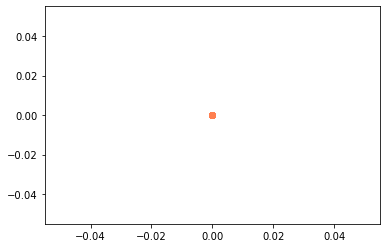

In [6]:
import matplotlib.pyplot as plt
from functions import regress
reduced=gss_mi.dropna(subset=["satcar"])
regress(reduced,"satcar","sex","age")

In [96]:
def regress(*args):
    #import dependencies
    import sklearn as sk
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    from sklearn import feature_selection
    import statsmodels.api as sm
    from patsy import dmatrices
    import matplotlib.pyplot as plt

    #define arguments
    dataframe=args[0]
    y=args[1]
    xvars=[]
    for i in range(2,len(args)):
        xvars.append(args[i])
    x = dataframe[[item for item in xvars]]
    y = dataframe[y].values.reshape(-1, 1)
    #fit the model
    model.fit(x,y)

    #Generate Fit Statistics
    ##prep data for patsy
    list=[]
    for item in xvars:
        list.append(f' + {item}')
    string="".join(list)
    newstring=string[3:]

    ind=args[1]
    ind=ind.strip('"')

    ##Get fitstats from patsy
    Y,X = dmatrices(f"{ind} ~ {newstring}", data=dataframe, return_type="dataframe")
    ols = sm.OLS(Y, X)
    ols_result = ols.fit()
    print(ols_result.summary())

    #Plot the Residuals
    print("\n Residual Plot")
    import matplotlib.pyplot as plt
    predictions = model.predict(x)
    plt.scatter(predictions, predictions - y, color='coral',linewidths=0.5)
    plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max(), color='brown', linewidth=3)
    plt.show()

In [14]:
clean=gss.dropna(subset=["satcar","carbuya", "carbuyb", "carbuyc","carbuyd","carbuye","carbuyf","carbuyg", "satcar"])

                            OLS Regression Results                            
Dep. Variable:                 satcar   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     2.763
Date:                Fri, 26 Mar 2021   Prob (F-statistic):            0.00592
Time:                        07:40:21   Log-Likelihood:                -281.64
No. Observations:                 291   AIC:                             581.3
Df Residuals:                     282   BIC:                             614.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0088      0.403      7.463      0.0

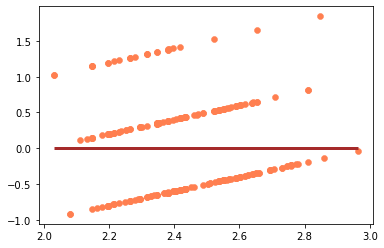

In [16]:
regress(clean, "satcar","sex", "carbuya", "carbuyb", "carbuyc", "carbuyd", "carbuye", "carbuyf", "carbuyg", "carbuye","carbuyf","carbuyg")

In [10]:
clean=gss.dropna(subset=["carbuya", "carbuyb", "carbuyc","carbuyd","carbuye","carbuyf","carbuyg", "satcar"])

In [ ]:
##############
#Summary Stats
##############
def summarize(dataframe,variable):
    #dependencies
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    #define arguments
    dfvar=dataframe[variable]
    description=dfvar.describe()
    print(description)
    print("\n")
    checkvar=dfvar.dropna()
    if (checkvar % 1  == 0).all()== True and len(set(checkvar))<10:
        cats=set(checkvar)
        print("Obs per category")
        print("------------------")
        for item in cats:
           count=len(dataframe.loc[dfvar == item])
           percent=round(count/len(dfvar)*100, 2)
           print(f"{item}-> {count} ({percent}%)")
        values=list(set(checkvar))
        marks= len(values)
        hist=plt.hist(dfvar, bins=len(values))
        plt.xticks(ticks=values)
        plt.savefig(f"../figures/Histogram_{variable}.png")
        plt.show()
        print(hist)
    else:
        hist=plt.hist(dfvar, bins=10)
        plt.savefig(f"../figures/Histogram_{variable}.png")
        plt.show()
        print(hist)
#######################################################################
#Numerify
#Turns all categorical variables to numeric with reference category "0"
########################################################################
def numerify(dataframe):
    for thing in dataframe.columns:
        var=dataframe[thing]
        has_string=False
        values=set(dataframe[thing])
        for item in var:
            if type(item)==str:
                has_string=True
                break
        if has_string == True:
            counter=0
            for item in values:
                dataframe.replace(to_replace=item, value=counter, inplace=True)
                counter+=1
        elif (var.fillna(-9999) % 1  == 0).all()== False:
            counter=0
            for item in values:
                dataframe.replace(to_replace=item, value=counter, inplace=True)
                counter+=1
        else:
            continue
 #################           
#Linear Regression
##################
#Arg 1 = dataset, Args 2-N = "variable" (name in quotes)

def regress(*args):
    #import dependencies
    import sklearn as sk
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    from sklearn import feature_selection
    import statsmodels.api as sm
    from patsy import dmatrices
    import matplotlib.pyplot as plt

    #define arguments
    dataframe=args[0]
    y=args[1]
    xvars=[]
    for i in range(2,len(args)):
        xvars.append(args[i])
    x = dataframe[[item for item in xvars]]
    y = dataframe[y].values.reshape(-1, 1)
    #fit the model
    model.fit(x,y)

    #Generate Fit Statistics
    ##prep data for patsy
    list=[]
    for item in xvars:
        list.append(f' + {item}')
    string="".join(list)
    newstring=string[3:]

    ind=args[1]
    ind=ind.strip('"')

    ##Get fitstats from patsy
    Y,X = dmatrices(f"{ind} ~ {newstring}", data=dataframe, return_type="dataframe")
    ols = sm.OLS(Y, X)
    ols_result = ols.fit()
    print(ols_result.summary())

    #Plot the Residuals
    print("\n Residual Plot")
    predictions = model.predict(x)
    plt.scatter(predictions, predictions - y, color='coral',linewidths=0.5)
    plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max(), color='brown', linewidth=3)
    plt.show()

#####################
#Logistic Regression
#####################
#Arg 1 = dataset, Args 2-N = "variable" (name in quotes)

def linregress(*args):
    #import dependencies
    import sklearn as sk
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression()
    from sklearn import feature_selection
    import statsmodels.api as sm
    from patsy import dmatrices
    import numpy as np

    #define arguments
    dataframe=args[0]
    y=args[1]
    xvars=[]
    for i in range(2,len(args)):
        xvars.append(args[i])
    x = dataframe[[item for item in xvars]]
    y = dataframe[y]
    #fit the model
    model.fit(x,y)
    
    #Generate Fit Statistics
    ##prep data for patsy
    list=[]
    for item in xvars:
        list.append(f' + {item}')
    string="".join(list)
    newstring=string[3:]

    ind=args[1]
    ind=ind.strip('"')

    ##Fit the Model
    Y,X = dmatrices(f"{ind} ~ {newstring}", data=dataframe, return_type="dataframe")
    logit = sm.Logit(Y, X)
    logit_result = logit.fit()

    #Print Log Odds
    print("LOG ODDS")
    print(logit_result.summary())
    print(np.exp(logit_result.params))

    #Plot the Residuals
    print("\n Residual Plot")
    from sklearn.linear_model import Ridge
    from yellowbrick.datasets import load_concrete
    from yellowbrick.regressor import ResidualsPlot
    
    model = Ridge()

    visualizer = ResidualsPlot(model, hist=True)
    y2= y.values.reshape(-1, 1)
    visualizer.fit(x, y2)  # Fit the training data to the visualizer
    visualizer.score(x, y2)  # Evaluate the model on the test data
    visualizer.show()                 # Finalize and render the figure

    #predictions = model.predict(x)
    #plt.scatter(predictions, predictions - y, color='coral',linewidths=0.5)
    #plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max(), color='brown', linewidth=3)
    #plt.show()




SyntaxError: invalid syntax (<ipython-input-9-64cd457c8cb0>, line 1)